# 10. 시계열을 위한 딥러닝
## 10.2 온도 예측 문제

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-09-11 02:30:26--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.182.101.168, 52.217.112.16, 3.5.22.178, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.182.101.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.7MB/s    in 0.7s    

2024-09-11 02:30:27 (18.7 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
# 10-1 예나 날씨 데이터셋 조사하기

import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
# 10-2 데이터 파싱

import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

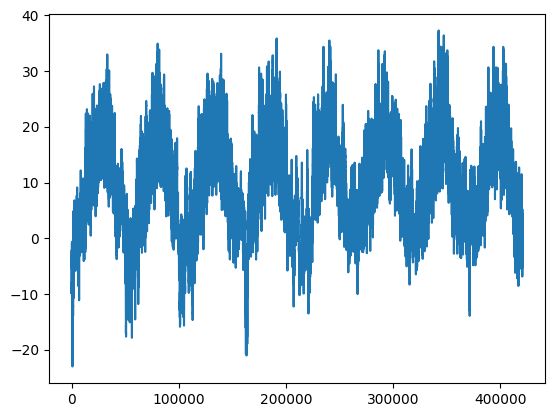

In [ ]:
# 10-3 전체 온도를 그래프로 그리기

from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

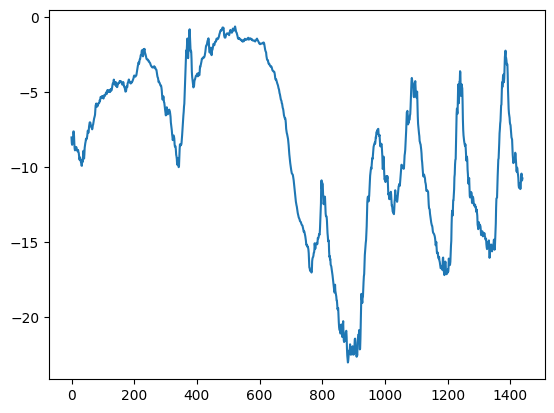

In [ ]:
# 10-4 처음 10일간의 온도를 그래프로 그리기

plt.plot(range(1440), temperature[:1440])
plt.show()

In [ ]:
# 10-5 각 분할에 사용할 샘플 개수 계산하기

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


# 10.2.1 데이터 준비

In [ ]:
# 10-6 데이터 정규화

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
# 10-7 훈련, 검증, 테스트 데이터셋 만들기


sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [ ]:
# 10-8 훈련 데이터셋의 배치 크기 확인하기

for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


# 10.2.2 상식 수준의 기준점

In [ ]:
# 10-9 상식 수준 모델의 MAE 계산하기

def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


# 10.2.3 기본적인 머신 러닝 모델 시도해보기

In [ ]:
# 10-10 밀집 연결 모델 훈련하고 평가하기

from tensorflow import keras
from tensorflow.keras import layers

# 입력 형상을 명확하게 정의
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Flatten 레이어 적용
x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)


callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 68s 81ms/step - loss: 19.1723 - mae: 3.3146 - val_loss: 10.4270 - val_mae: 2.5460
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 86s 105ms/step - loss: 9.3709 - mae: 2.4016 - val_loss: 13.0030 - val_mae: 2.8622
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 120s 78ms/step - loss: 8.5092 - mae: 2.2939 - val_loss: 11.2243 - val_mae: 2.6522
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 59s 72ms/step - loss: 8.0953 - mae: 2.2401 - val_loss: 10.7308 - val_mae: 2.5951
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 79s 69ms/step - loss: 7.7574 - mae: 2.1953 - val_loss: 10.3813 - val_mae: 2.5459
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 7.4517 - mae: 2.1510 - val_loss: 11.7291 - val_mae: 2.7144
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 70ms/step - loss: 7.2627 - mae: 2.1248 - val_loss: 11.2876 - val_mae: 2.6631
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 69ms/step - loss: 7.1259 - mae: 2.1060 - val_loss: 11.3704 - val_mae: 2.6729
Epoch 9/10
819/819 ━━━━━━━━━━

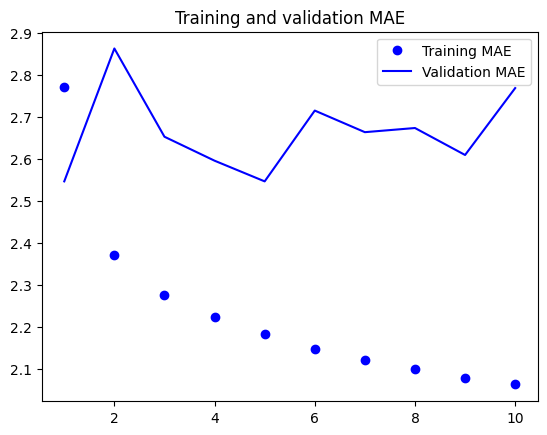

In [ ]:
# 10-11 결과 그래프 그리기

import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 10.2.4 1D 합성곱 모델 시도해보기

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 86s 103ms/step - loss: 32.5774 - mae: 4.3819 - val_loss: 15.9218 - val_mae: 3.1670
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 166s 133ms/step - loss: 16.2038 - mae: 3.2077 - val_loss: 14.9756 - val_mae: 3.0478
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 122s 108ms/step - loss: 14.5054 - mae: 3.0262 - val_loss: 20.3835 - val_mae: 3.5554
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 103ms/step - loss: 13.6097 - mae: 2.9249 - val_loss: 14.8948 - val_mae: 3.0523
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 155s 119ms/step - loss: 12.8798 - mae: 2.8425 - val_loss: 15.2524 - val_mae: 3.0949
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - loss: 12.2249 - mae: 2.7693 - val_loss: 15.0518 - val_mae: 3.0488
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 116ms/step - loss: 11.8314 - mae: 2.7249 - val_loss: 14.8696 - val_mae: 3.0432
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 96s 117ms/step - loss: 11.4334 - mae: 2.6733 - val_loss: 16.5736 - val_mae: 3.2092
Epoch 9/10


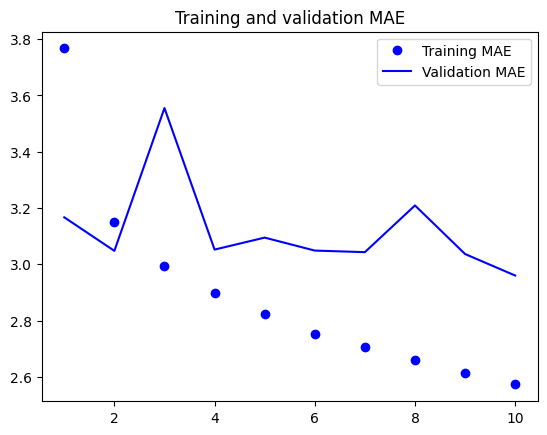

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 10.2.5 첫 번째 순환 신경망

In [ ]:
# 10-12 간단한 LSTM 기반 모델

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 138s 136ms/step - loss: 74.9315 - mae: 6.6218 - val_loss: 13.0310 - val_mae: 2.7574
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 134ms/step - loss: 12.2514 - mae: 2.7077 - val_loss: 10.1716 - val_mae: 2.4914
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 134ms/step - loss: 10.1350 - mae: 2.4867 - val_loss: 9.8849 - val_mae: 2.4547
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 135ms/step - loss: 9.6733 - mae: 2.4289 - val_loss: 9.9386 - val_mae: 2.4398
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 107s 131ms/step - loss: 9.4398 - mae: 2.3963 - val_loss: 9.8932 - val_mae: 2.4289
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 109s 132ms/step - loss: 9.2503 - mae: 2.3690 - val_loss: 10.2787 - val_mae: 2.4642
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 143s 134ms/step - loss: 9.1067 - mae: 2.3481 - val_loss: 10.5837 - val_mae: 2.4871
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 146s 138ms/step - loss: 8.9847 - mae: 2.3298 - val_loss: 11.3110 - val_mae: 2.5357
Epoch 9/10
819/8

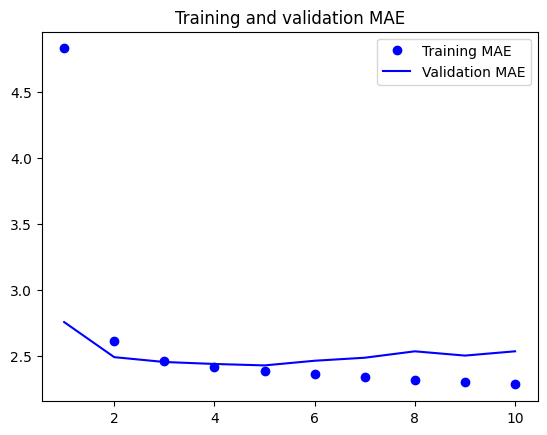

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 10.3 순환 신경망 이해하기

In [ ]:
# 10-13 의사 코드로 표현한 RNN

state_t = 0
for input_t in input_sequence:
  output_t = f(input_t, state_t)
  state_t = output_t

In [ ]:
# 10-14 좀 더 자세한 의사 코드로 표현한 RNN

state_t = 0
for input_t in input_sequence:
  output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
  state_t = output_t

In [ ]:
# 10-15 넘파이로 구현한 간단한 RNN

import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

# 10.3.1 케라스의 순환 층

In [ ]:
# 10-16 어떤 길이의 시퀀스도 처리할 수 있는 RNN 층

num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [ ]:
# 10-17 마지막 출력 스텝만 반환하는 RNN 층

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


In [ ]:
# 10-18 전체 출력 시퀀스를 반환하는 RNN 층

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


In [ ]:
# 10-19 스태킹(stacking) RNN 층

inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

In [ ]:
# 10-20 LSTM 구조의 의사 코드(1/2)

output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wf) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

In [ ]:
# 10-21 LSTM 구조의 의사 코드(2/2)

c_t+1 = i_t * k_t + c_t * f_t

# 10.4 순환 신경망의 고급 사용법
## 10.4.1 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

In [ ]:
# 10-22 드롭아웃 규제를 적용한 LSTM 모델 훈련하고 평가하기

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# 훈련 속도를 놓이기 위해 순환 드롭아웃을 제외합니다.
#x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 173s 208ms/step - loss: 48.7115 - mae: 5.1581 - val_loss: 10.2004 - val_mae: 2.4699
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 141s 171ms/step - loss: 14.9503 - mae: 2.9973 - val_loss: 9.9518 - val_mae: 2.4604
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 146s 177ms/step - loss: 13.8591 - mae: 2.8785 - val_loss: 9.5696 - val_mae: 2.4029
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 197s 172ms/step - loss: 13.1506 - mae: 2.8031 - val_loss: 9.3958 - val_mae: 2.3810
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 170ms/step - loss: 12.4950 - mae: 2.7300 - val_loss: 9.8397 - val_mae: 2.4380
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 139s 169ms/step - loss: 11.8706 - mae: 2.6673 - val_loss: 10.4930 - val_mae: 2.5004
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - loss: 11.3272 - mae: 2.6022 - val_loss: 9.7146 - val_mae: 2.4349
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 170ms/step - loss: 11.0089 - mae: 2.5564 - val_loss: 10.7873 - val_mae: 2.5533
Epoch 9/50
81

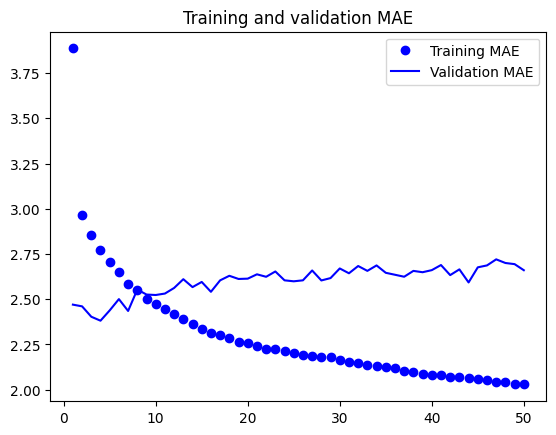

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

# 10.4.2 스태킹 순환 층

In [ ]:
# 10-23 드롭아웃 규제와 스태킹을 적용한 GRU 모델을 훈련하고 평가하기

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 288s 345ms/step - loss: 42.0234 - mae: 4.7740 - val_loss: 9.3082 - val_mae: 2.3697
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 285s 347ms/step - loss: 13.7953 - mae: 2.8766 - val_loss: 9.1368 - val_mae: 2.3470
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 287s 349ms/step - loss: 12.8439 - mae: 2.7756 - val_loss: 9.2712 - val_mae: 2.3526
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 323s 394ms/step - loss: 12.0198 - mae: 2.6854 - val_loss: 9.9572 - val_mae: 2.4430
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 340s 343ms/step - loss: 11.2869 - mae: 2.6053 - val_loss: 10.1445 - val_mae: 2.4662
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 280s 342ms/step - loss: 10.5811 - mae: 2.5250 - val_loss: 10.4514 - val_mae: 2.5160
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 330s 351ms/step - loss: 9.9284 - mae: 2.4488 - val_loss: 11.0734 - val_mae: 2.5748
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 360s 398ms/step - loss: 9.2348 - mae: 2.3557 - val_loss: 11.0604 - val_mae: 2.5852
Epoch 9/50
819

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 10.4.3 양방향 RNN 사용하기

In [ ]:
# 10-24 양방향 LSTM 모델 훈련하고 평가하기

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)